In [1]:
import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt

from counterfactualgp.gp import GP
from counterfactualgp.mean import linear_mean
from counterfactualgp.cov import iid_cov, se_cov

In [2]:
with open('dataset/data_set_linear.pkl', 'rb') as fin:
    data = pickle.load(fin)

obj= [5274.20287021]
obj= [4998.60105686]
obj= [4662.22381567]
obj= [4346.9111116]
obj= [3895.73444745]
obj= [3683.0571393]
obj= [3641.08006139]
obj= [3616.64238971]
obj= [3611.38369142]
obj= [3609.07689281]
obj= [3609.04709263]
obj= [3609.04591298]
obj= [3609.0459091]
obj= [3609.04590908]
obj= [3609.04590908]


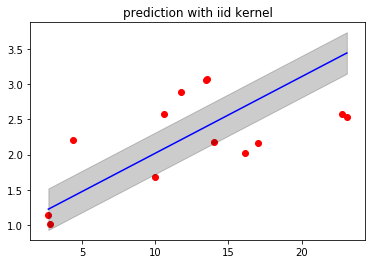

In [3]:
m = linear_mean(1)
gp = GP(m, iid_cov)
gp.fit(data['training'], init = False)

y, x = data['testing'][0]
t, rx = x
t_hat = np.linspace(t[0], t[-1], num = 100)
rx_hat = np.array([0] * len(t_hat))

yhat, cov_hat = gp.predict((t_hat, rx_hat), y, x)
y_std = np.diag(cov_hat)

plt.plot(t_hat, yhat, color='b')
plt.scatter(t, y, marker='o', color='r')
plt.fill_between(t_hat, yhat - y_std, yhat + y_std,
                     alpha=0.2, color='k')
plt.title('prediction with iid kernel')
plt.show()

obj= [5870.62898462]
obj= [4923.44243522]
obj= [4879.57384029]
obj= [4529.04149493]
obj= [4388.26300779]
obj= [4383.14771056]
obj= [4383.09173018]
obj= [4383.09132105]
obj= [4383.0913154]
obj= [4383.0913154]
obj= [4383.0913154]


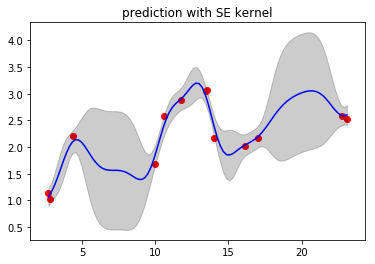

In [4]:
m = linear_mean(1)
gp = GP(m, se_cov(a=1.0, l=1.0))
gp.fit(data['training'], init = False)

y, x = data['testing'][0]
t, rx = x
t_hat = np.linspace(t[0], t[-1], num = 100)
rx_hat = np.array([0] * len(t_hat))

yhat, cov_hat = gp.predict((t_hat, rx_hat), y, x)
y_std = np.diag(cov_hat)

plt.plot(t_hat, yhat, color='b')
plt.scatter(t, y, marker='o', color='r')
plt.fill_between(t_hat, yhat - y_std, yhat + y_std,
                     alpha=0.2, color='k')
plt.title('prediction with SE kernel')
plt.show()